In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../../dataset/KEY.csv')
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define CNN-LSTM Model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
# Define the model architecture
model = Sequential()

# Add the CNN layers
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(100, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Add the LSTM layer
model.add(LSTM(units=64, return_sequences=True,activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=64,activation='relu'))

# Add the dense layers
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
41/41 [==============================] - 9s 52ms/step - loss: 0.0316 - val_loss: 0.0208
Epoch 2/100
41/41 [==============================] - 2s 39ms/step - loss: 0.0067 - val_loss: 0.0172
Epoch 3/100
41/41 [==============================] - 2s 41ms/step - loss: 0.0062 - val_loss: 0.0138
Epoch 4/100
41/41 [==============================] - 2s 41ms/step - loss: 0.0056 - val_loss: 0.0177
Epoch 5/100
41/41 [==============================] - 2s 42ms/step - loss: 0.0051 - val_loss: 0.0155
Epoch 6/100
41/41 [==============================] - 2s 47ms/step - loss: 0.0046 - val_loss: 0.0093
Epoch 7/100
41/41 [==============================] - 2s 40ms/step - loss: 0.0041 - val_loss: 0.0053
Epoch 8/100
41/41 [==============================] - 2s 38ms/step - loss: 0.0038 - val_loss: 0.0114
Epoch 9/100
41/41 [==============================] - 1s 37ms/step - loss: 0.0037 - val_loss: 0.0054
Epoch 10/100
41/41 [==============================] - 1s 36ms/step - loss: 0.0033 - val_loss: 0.0076

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

8/8 [==============================] - 0s 3ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 0.8155276586897038
Testing RMSE: 1.310791629991684


In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=277
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps ,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.70046944 0.66666667 0.6643193  0.67230052 0.63849761 0.64600934
 0.65727695 0.68403761 0.66056343 0.64929582 0.63239437 0.62018779
 0.60422535 0.60187798 0.60610333 0.60187798 0.63427225 0.60093897
 0.59389676 0.59201878 0.62159629 0.62629103 0.64835681 0.66713615
 0.66244131 0.66901404 0.64741784 0.66713615 0.65399056 0.65492958
 0.65774643 0.63896714 0.60751174 0.56619718 0.54835676 0.55539911
 0.56478873 0.53380282 0.54225352 0.55446009 0.54929577 0.53004695
 0.56901408 0.55633798 0.55868549 0.55305164 0.54084507 0.55352113
 0.54788728 0.54178404 0.55915498 0.55305164 0.54929577 0.54460089
 0.52957746 0.51267601 0.55446009 0.56291085 0.57934268 0.58356803
 0.58920188 0.57887329 0.58169014 0.55962437 0.57793427 0.57276995
 0.59107977 0.59061038 0.57605634 0.58215967 0.56478873 0.57981216
 0.58403756 0.58215967 0.61784042 0.63380277 0.64319249 0.64507047
 0.66056343 0.64460099 0.65399056 0.63802812 0.61032859 0.61314554
 0.61220657 0.62676052 0.5971831  0.57746479 0.570

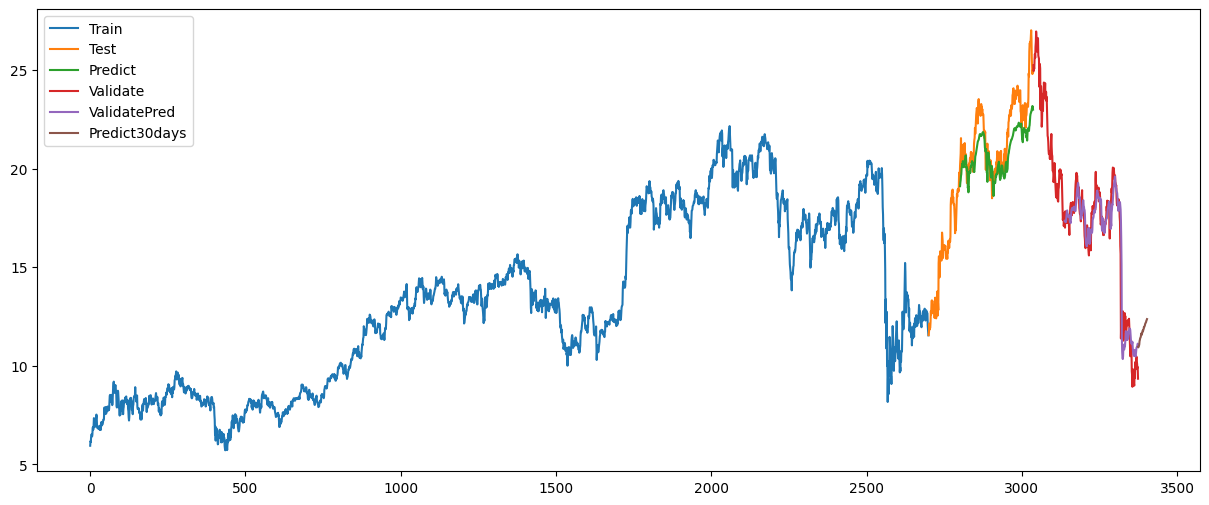

In [15]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.subplots(figsize=(15, 6))
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [16]:
scaler.inverse_transform(lst_output)

array([[10.95777754],
       [10.92908823],
       [10.96176053],
       [11.01057013],
       [11.06609072],
       [11.24500867],
       [11.30620428],
       [11.39308029],
       [11.42097104],
       [11.46390122],
       [11.58136393],
       [11.64334414],
       [11.56211965],
       [11.63349347],
       [11.68967869],
       [11.78326634],
       [11.74409157],
       [11.80906862],
       [11.85347342],
       [11.95719357],
       [11.95061081],
       [12.00070458],
       [12.03001598],
       [12.12005325],
       [12.14385468],
       [12.19183588],
       [12.20902344],
       [12.28541718],
       [12.31561602],
       [12.36289704]])